1. For fig2C, I need the weights of feature ranking to classify age without Klotho (i.e. without ch4 and ch11). 
2. For fig2D, rug plot for CD63. Also the mean and variance
3. For fig2E, rug plot for cd81. Also the mean and variance
4. For fig3G, rug plot for Klotho. In this case, add intensity (your values) columns for alt-kl (ch4) and klotho (ch11) and then plot them. Also send me the mean and variance. 
5. For fig3I, linear regression based weights for prediction of klotho. Can you send me two sets of analysis here: prediction of only ch11 and prediction of ch4+ch11 
6. For fig3J, Correlation between cd82 and klotho. I can make this with the sheet you had sent me. 
7. For fig3K, the heat map like thing that you suggested where the rows are all features and columns are age and Klotho. I need numbers (weights?) to work with. 

I think for most analysis, let's consider Klotho intensity to be a sum of alt-kl (ch4) and klotho (ch11). 

When I checked the link you had shared with me, I realized that at some places (classification of age in particular) you had kept ch4 in the list but removed ch2. So I wasn't sure if I was looking at the right thing. 

I'd be happy to do this with you at your place (not school) tomorrow or today, whatever is convenient for you. 


## HouseKeeping

In [19]:
% load_ext autoreload
% autoreload 2
import pandas as pd
from BioAnalysis import BioAnalysis
import numpy as np
from tqdm import tqdm, trange
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import operator 
from collections import OrderedDict
from sklearn.linear_model import RANSACRegressor
from sklearn import preprocessing
from scipy.stats import fisher_exact
from IPython.display import HTML, display
import csv
import sys
!{sys.executable} -m pip install seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable


In [20]:
db = pd.read_csv('../Amrita_29feb/features.csv')
# lets subtract the bgmean from the intensity

columns = list(db.columns)

# intensities = [s for s in columns if "Intensity_MC" in s]
# bkgds = [s for s in columns if "Bkgd" in s]

# for a,b in zip(intensities, bkgds):  
#     db[a] = db[a] - db[b]
    
analysis = BioAnalysis('../Amrita_29feb/')
points = analysis.points


filtered = analysis.getFilteredIndices()

filtered_db = pd.DataFrame(columns=db.columns)
for idx,row in enumerate(tqdm(filtered)):
    filtered_db = filtered_db.append(db[(db.Class == int(row[0])) & (db["Object Number"]==int(row[1]))])
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch02')] = points[idx, 0]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch07')] = points[idx, 1]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch11')] = points[idx, 2]
    try:
        filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch04')] = points[idx, 3]
    except:
        pass

100%|██████████| 13206/13206 [03:12<00:00, 68.65it/s]


In [3]:
# Do not run this more than once!

In [4]:
filtered_db['Intensity_MC_KL'] = filtered_db['Intensity_MC_Ch11'] + filtered_db['Intensity_MC_Ch04']
unfiltered_db = filtered_db


In [5]:
filtered_db = unfiltered_db.loc[:,~unfiltered_db.columns.duplicated()]
data = []
data.append('Class')
data.append('Object Number')
data.append('Area_M01')
data.append('Area_M02')
# data.append('Area_M03')
data.append('Area_M04')
data.append('Area_M06')
data.append('Area_M07')
data.append('Area_M09')
# data.append('Area_M11')
data.append('Aspect Ratio_M01')
data.append('Aspect Ratio_M06')
data.append('Aspect Ratio_M09')
data.append('Modulation_M02_Ch02')
data.append('Modulation_M03_Ch03')
# data.append('Modulation_M04_Ch04')
data.append('Modulation_M07_Ch07')
# data.append('Modulation_M11_Ch11')
data.append('Intensity_MC_Ch02')
# data.append('Intensity_MC_Ch03')
# data.append('Intensity_MC_Ch04')
data.append('Intensity_MC_Ch07')
# data.append('Intensity_MC_Ch11')
data
filtered_db = unfiltered_db[data]
#     if idx%100==0:
#         sys.stdout.write(str(idx) + '\r')
#         sys.stdout.flush()
print([column for column in filtered_db.columns])

['Class', 'Object Number', 'Area_M01', 'Area_M03', 'Area_M04', 'Area_M06', 'Area_M07', 'Area_M09', 'Aspect Ratio_M01', 'Aspect Ratio_M06', 'Aspect Ratio_M09', 'Modulation_M02_Ch02', 'Modulation_M03_Ch03', 'Modulation_M07_Ch07', 'Intensity_MC_Ch02', 'Intensity_MC_Ch07']


## What features can predict age (with and without ch1,6,9)

### With All channels

Feature Importances:
Raw Max Pixel_MC_Ch09 0.152
Max Pixel_MC_Ch09 0.121
Modulation_M04_Ch04 0.120
Area_M02 0.085
Raw Max Pixel_MC_Ch01 0.062
Max Pixel_MC_Ch01 0.048
Intensity_MC_Ch02 0.038
Median Pixel_M02_Ch02 0.023
Raw Min Pixel_MC_Ch07 0.012
Max Pixel_MC_Ch04 0.011
Cross-validation Score: 0.843100383089
Cross-validation Variance: 0.0115856332641


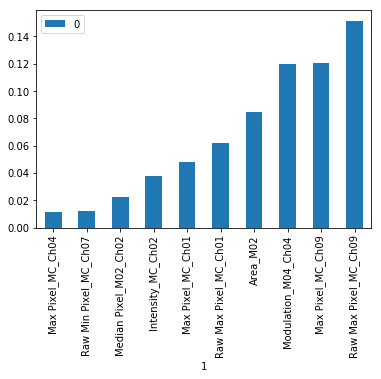

In [12]:
## new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.std(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
df = pd.DataFrame(list(zip(values,names))).set_index(1)

plt.figure()
df.plot.bar()

### Without Ch 1, 6, 9

Feature Importances:
Intensity_MC_Ch02 0.230
Modulation_M02_Ch02 0.188
Intensity_MC_Ch07 0.134
Modulation_M07_Ch07 0.130
Modulation_M03_Ch03 0.126
Area_M03 0.107
Area_M07 0.084
Area_M03 0.000
Area_M03 0.000
Area_M03 0.000
Cross-validation Score: 0.658568055747


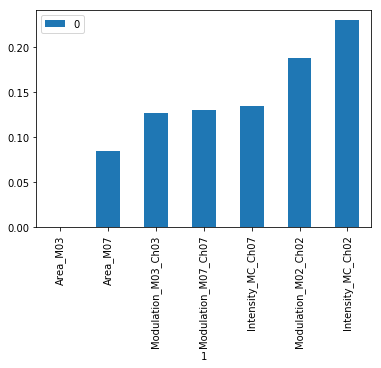

In [13]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())

df = pd.DataFrame(list(zip(values,names))).set_index(1)

df.plot.bar()


## What features predict ch11 and ch4 activation? Both are Klotho but different forms of it. 

### Ch11

Feature Importances:
Intensity_MC_Ch07 0.003
Area_M07 0.002
Modulation_M07_Ch07 0.001
Aspect Ratio_M01 0.000
Area_M06 0.000
Area_M06 0.000
Area_M06 0.000
Area_M06 0.000
Area_M06 0.000
Area_M06 0.000
Cross-validation Score: -4.40480005193e-05
Cross-validation Score Var: 2.96374365757e-10


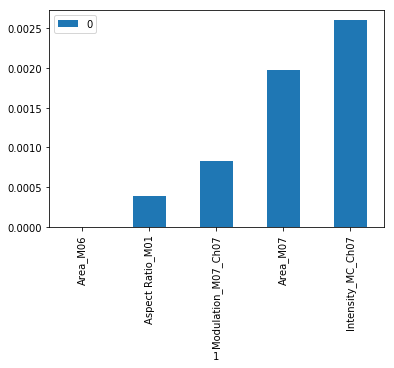

In [7]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = unfiltered_db.Intensity_MC_Ch11.to_numpy()
# Y = Y>0 # ch11> = 1, ch11< = 0
# print(np.count_nonzero(Y))
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "Aspect Ratio_M02" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
# X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# Min Max scaler to normalize all data:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.to_numpy())
y_scaled = Y/np.linalg.norm(Y)
# train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
reg = LinearRegression()
sol = reg.fit(x_scaled,y_scaled)

# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, x_scaled, y_scaled, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())

df = pd.DataFrame(list(zip(values,names))).set_index(1)

df.plot.bar()

### Ch04

Feature Importances:
Modulation_M02_Ch02 0.004
Area_M03 0.004
Intensity_MC_Ch07 0.003
Area_M01 0.002
Aspect Ratio_M06 0.001
Aspect Ratio_M09 0.000
Area_M07 0.000
Intensity_MC_Ch02 0.000
Area_M01 0.000
Area_M01 0.000
Cross-validation Score: -4.57626005276e-05
Cross-validation Score Var: 2.51332692656e-10


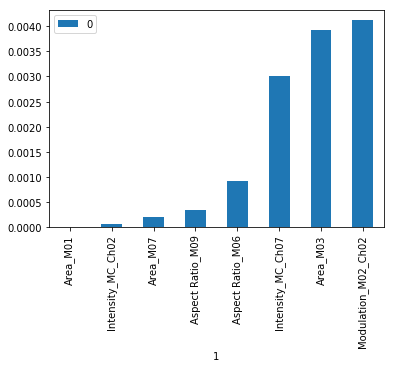

In [8]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = unfiltered_db.Intensity_MC_Ch04.to_numpy()
# Y = Y>0 # ch04> = 1, ch04< = 0
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch01" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch09" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch06" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch04" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# # train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
# sol = clf.fit(X.to_numpy(),Y.astype('int'))

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.to_numpy())
y_scaled = Y/np.linalg.norm(Y)
# Print out the feature importances
reg = LinearRegression()
sol = reg.fit(x_scaled,y_scaled)
# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, x_scaled, y_scaled,cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
# plt.figure()
# plt.bar(names, values)
# plt.xticks(rotation=90)
# plt.show()
df = pd.DataFrame(list(zip(values,names))).set_index(1)

df.plot.bar()

## Correlation between ch7 and ch11. 

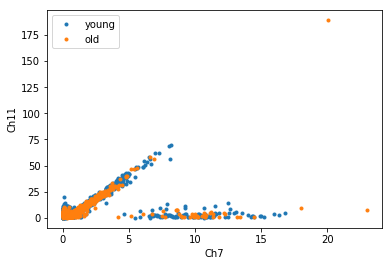

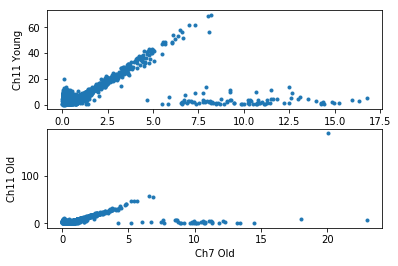

Young Pearson's correlation coefficient
[[ 1.        0.436599]
 [ 0.436599  1.      ]]
Old Pearson's correlation coefficient
[[ 1.          0.52027704]
 [ 0.52027704  1.        ]]


In [21]:
new_db = unfiltered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.legend(['young', 'old'])
plt.xlabel('Ch7')
plt.ylabel('Ch11')
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch11 Old')
# plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch11_intensity))


### Let's try and run ransac on this example

  0%|          | 0/300 [00:00<?, ?it/s]

('took iterations:', 1, 'best model:', array([ -9.88428198e-01,   1.51689476e-01,   3.33900342e-05]), 'explains:', 6506)


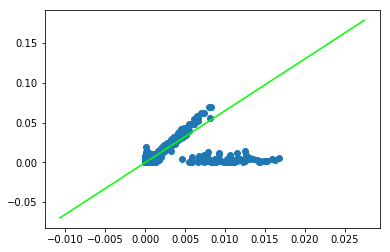

slope:0.153465346535


In [10]:
from ransac import *
X = young_ch7_intensity.to_numpy()/1000.0
Y = young_ch11_intensity.to_numpy()/1000.0
while X.shape[0]>20:
    inliers,model = ransac(X,Y)
    a,b,c = model
    print('slope:' + str(-b/a))
    X = X[inliers.flatten()<=0]
    Y = Y[inliers.flatten()<=0]
    if X.shape[0] <20:
        continue


In [11]:
print(X.shape)

X = X[inliers.flatten()>0,...]
X.shape

(0,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 6506

## Correlation between ch7 and ch4. 

In [18]:
new_db = filtered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch4_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch04
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch4_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch04

plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7')
plt.ylabel('Ch4')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch4 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch4 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch4_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch4_intensity))


AttributeError: 'DataFrame' object has no attribute 'Intensity_MC_Ch04'

In [ ]:
new_db = filtered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch4_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch02
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch4_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch02

plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7')
plt.ylabel('Ch4')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch4 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch4 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch4_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch4_intensity))

## Correlation between ch2 and ch11. 

In [ ]:
new_db = filtered_db
plt.figure()
young_ch2_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch2_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2')
plt.ylabel('Ch11')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch2 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2 Old')
plt.ylabel('Ch11 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch2_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch2_intensity, old_ch11_intensity))

## Correlation between ch2 and ch4. 

In [ ]:
new_db = filtered_db
plt.figure()
young_ch2_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_ch4_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch04
old_ch2_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_ch4_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch04

plt.plot(young_ch2_intensity, young_ch4_intensity, '.')
plt.plot(old_ch2_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch2')
plt.ylabel('Ch11')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch2_intensity, young_ch4_intensity, '.')
plt.xlabel('Ch2 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch2_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch2 Old')
plt.ylabel('Ch11 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch2_intensity, young_ch4_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch2_intensity, old_ch4_intensity))

## Ransac to do a line fit for the correlations ? 

## Differences in cd81, cd63 between young and old. 
Generated using code written by Ankit

In [ ]:
analysis.getContingencyMatrix()

In [ ]:
hist_range = [[0,150],[0,150],[0,25],[0,2000],[0,100],[0,100]]
# hist_range = []
dist = analysis.getTotalIntensityDistribution(hist_range)

labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL','Size CD63', 'Size CD81', 'Size KL']
for key in dist:
    print (key)
    for i,label in enumerate(labels):
        print(label)
        print('Mean: {0:.2f} Variance: {1:.2f}'.format(dist[key]['Mean'][i],dist[key]['Var'][i]))

In [ ]:
points_young = analysis.points_young
points_old = analysis.points_old

from scipy.stats import mannwhitneyu
print ('Mann Whitney U Test Resuts:')
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
for i in range(0,7):
    young = points_young[:,i]
    old = points_old[:,i]
    print(labels[i] + ': ' +  str(mannwhitneyu(young, old)[1]))

np.savetxt('points_young.csv', points_young, header='young\n'+','.join(labels),delimiter=',')
np.savetxt('points_old.csv', points_old, header='old\n'+','.join(labels),delimiter=',')

In [ ]:
%matplotlib inline
print(points_young.shape)
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
for i in range(0,6):
    fig=plt.figure()
    sns.distplot(points_young[:,i],hist=False,rug=True,rug_kws={'height':0.1})
    sns.distplot(points_old[:,i],hist=False,rug=True,rug_kws={'height':0.05})
    plt.legend(['Young', 'Old'])
    plt.title(labels[i])
    plt.tight_layout()


## What happens if we keep all background mean features:

In [ ]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # ch04> = 1, ch04< = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)


#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

## Is there a way to find out if most of ch11 is >0 in cells that are ch2<0 and ch7>0

In [ ]:
new_db = filtered_db
new_db = new_db[(new_db.Intensity_MC_Ch02 >0) & (new_db.Intensity_MC_Ch07>0)]
print('So what are we left with:', str(new_db.shape))
ch11 = new_db.Intensity_MC_Ch11
print('Ch11 positive:', np.count_nonzero(ch11>0))
print('Ch11 negative:', np.count_nonzero(ch11<=0))
print('Size of points young', analysis.points_young.shape[0])
print('Size of points old', analysis.points_old.shape[0])

## Using your method...if we do correlation between cd63 and KL or cd81 and KL.  Do we see the same thing?
### CD81 & KL

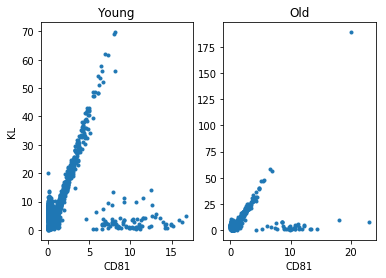

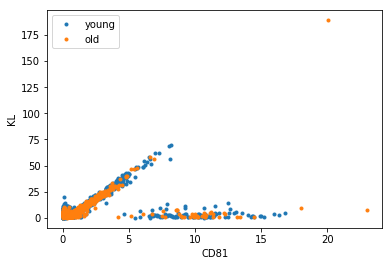

In [15]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.figure()
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')
plt.legend(['young', 'old'])
plt.show()

### CD63 and KL

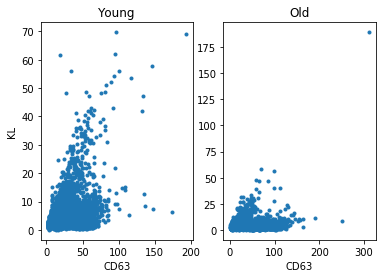

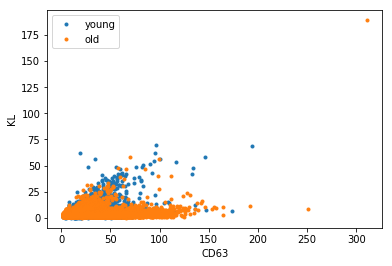

In [16]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.figure()
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')
plt.legend(['young', 'old'])

# Klotho intensity for CD81+ and CD81- particles

In [17]:
new_db = filtered_db

cd81_pos = new_db[(new_db.Intensity_MC_Ch07>0)]
cd81_neg = new_db[(new_db.Intensity_MC_Ch04<0)]

AttributeError: 'DataFrame' object has no attribute 'Intensity_MC_Ch04'

In [ ]:
y = np.sum(points_young[:,2:4],axis=1)
o = np.sum(points_old[:,2:4],axis=1)

print('Young Mean: ',np.mean(y))
print('Old Mean: ', np.mean(o))
print('Young Variance: ',np.var(y))
print('Old Variance: ', np.var(o))

plt.figure()
sns.distplot(y,hist=False)
sns.distplot(o,hist=False)